# Import data after Crawling+Large Language Model

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

In [4]:
df=pd.read_csv('data_hcm_llm.csv')

#Exploratory Data Analysis before Data Preprocessing

In [5]:
df.head()

,Price,Area,Bedrooms,WC,Describe,Khu_vuc,House Price,Area.1,Bedrooms.1,Bathrooms,Address.1,Length,Width,Facade,Floors
0,2.9 tỷ,214 m2,2 PN,2 WC,"- Nhà cấp 4, ngang 4m nở hậu 7.5m dài 37m công...",binhchanh,NaN,"214,","2,","2,","""Trần Văn Giàu"",","37,","4,","1,",NaN
1,12 triệu,200 m2,12 PN,12 WC,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,"null,","null,","null,","null,","null,","null,","null,",NaN
2,12 triệu,200 m2,12 PN,12 WC,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,850 triệu,60 m2,3 PN,2 WC,Nhà 1 triệt 1 lầu 3phong ngủ 2wc\r\nDiện tích ...,binhchanh,NaN,"60,","3,","2,","null,","4,","15,","1,",1.0
4,760 triệu,44 m2,2 PN,2 WC,"Tình trạng\r\nMới\r\nBÁN NHÀ HẺM ĐƯỜNG AN HẠ, ...",binhchanh,NaN,"44,","2,","2,","""Đường An Hạ, Bình Chánh"",","11,","4,","0,",NaN


<h4> Dataset nhóm chung em sẽ bao gồm các feature như sau:

*   6 feature đầu bao gồm : Price, Area, Bedrooms, WC, Describe, Khu_vuc là dữ liệu lấy được nhờ crawl data gốc của web.
*   9 feature sau bao gồm : House Price,	Area.1,	Bedrooms.1,	Bathroom,s	Address.1,	Length,	Width,	Facade,	Floors lấy được từ nhờ áp dụng LLM lên phần mô tả của mỗi bộ dữ liệu



In [6]:
df.shape

(9845, 15)

In [7]:
df.columns

Index(['Price', 'Area', 'Bedrooms', 'WC', 'Describe', 'Khu_vuc', 'House Price',
       'Area.1', 'Bedrooms.1', 'Bathrooms', 'Address.1', 'Length', 'Width',
       'Facade', 'Floors'],
      dtype='object')

In [8]:
count = df['Price'].str.contains(r'(?i)thỏa thuận', na=False).sum()

print(f'Số lượng giá trị "Thỏa thuận" hoặc "thoả thuận" trong cột Price là: {count}')

Số lượng giá trị "Thỏa thuận" hoặc "thoả thuận" trong cột Price là: 838


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Price        9845 non-null   object
 1   Area         8881 non-null   object
 2   Bedrooms     6020 non-null   object
 3   WC           5749 non-null   object
 4   Describe     9845 non-null   object
 5   Khu_vuc      9845 non-null   object
 6   House Price  6342 non-null   object
 7   Area.1       9600 non-null   object
 8   Bedrooms.1   9410 non-null   object
 9   Bathrooms    9597 non-null   object
 10  Address.1    9599 non-null   object
 11  Length       9598 non-null   object
 12  Width        9599 non-null   object
 13  Facade       9598 non-null   object
 14  Floors       8339 non-null   object
dtypes: object(15)
memory usage: 1.1+ MB


In [10]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

display_missing(df)

Price column missing values: 0
Area column missing values: 964
Bedrooms column missing values: 3825
WC column missing values: 4096
Describe column missing values: 0
Khu_vuc column missing values: 0
House Price column missing values: 3503
Area.1 column missing values: 245
Bedrooms.1 column missing values: 435
Bathrooms column missing values: 248
Address.1 column missing values: 246
Length column missing values: 247
Width column missing values: 246
Facade column missing values: 247
Floors column missing values: 1506




<h4> Điều này cho nhóm em thấy dữ liệu trong 2 feature là Bedrooms và WC có số lượng missing values cao hơn hẳn so với các feature khác <h4>

<Axes: >

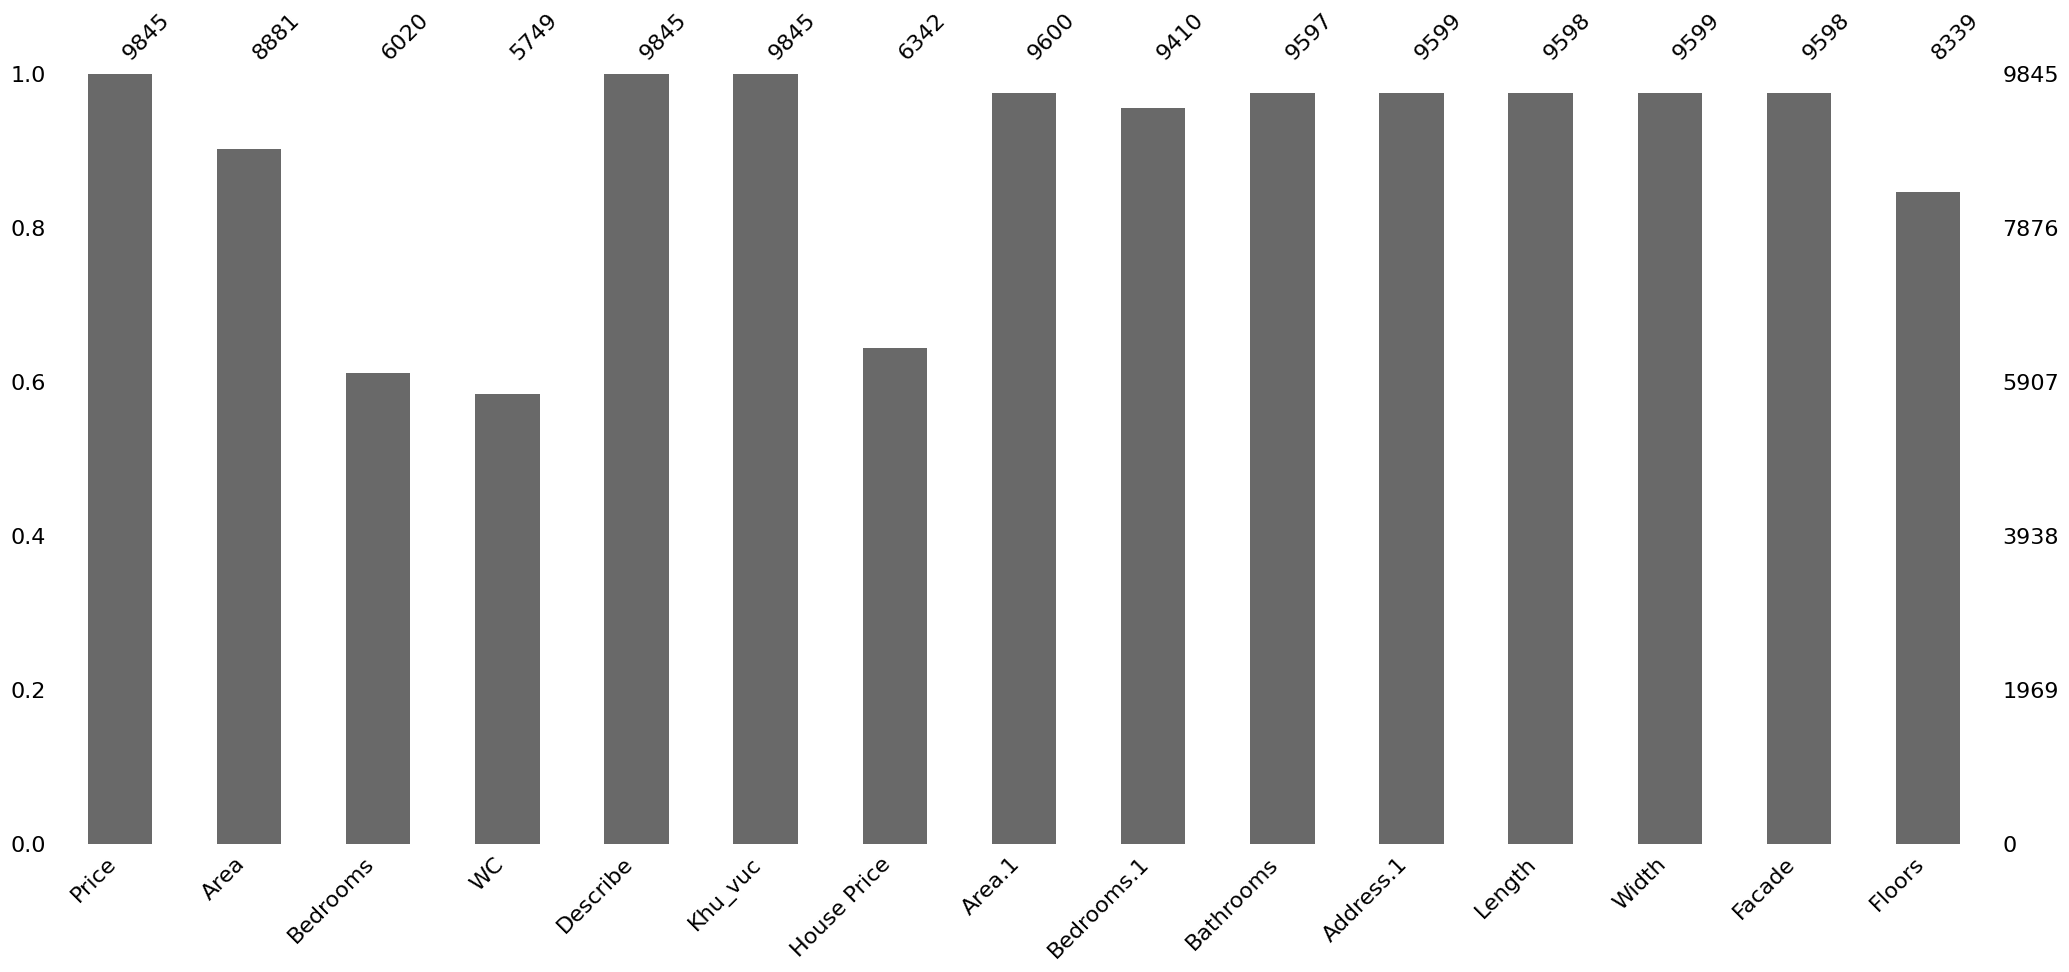

In [11]:
import missingno as msno
msno.bar(df)

<Axes: >

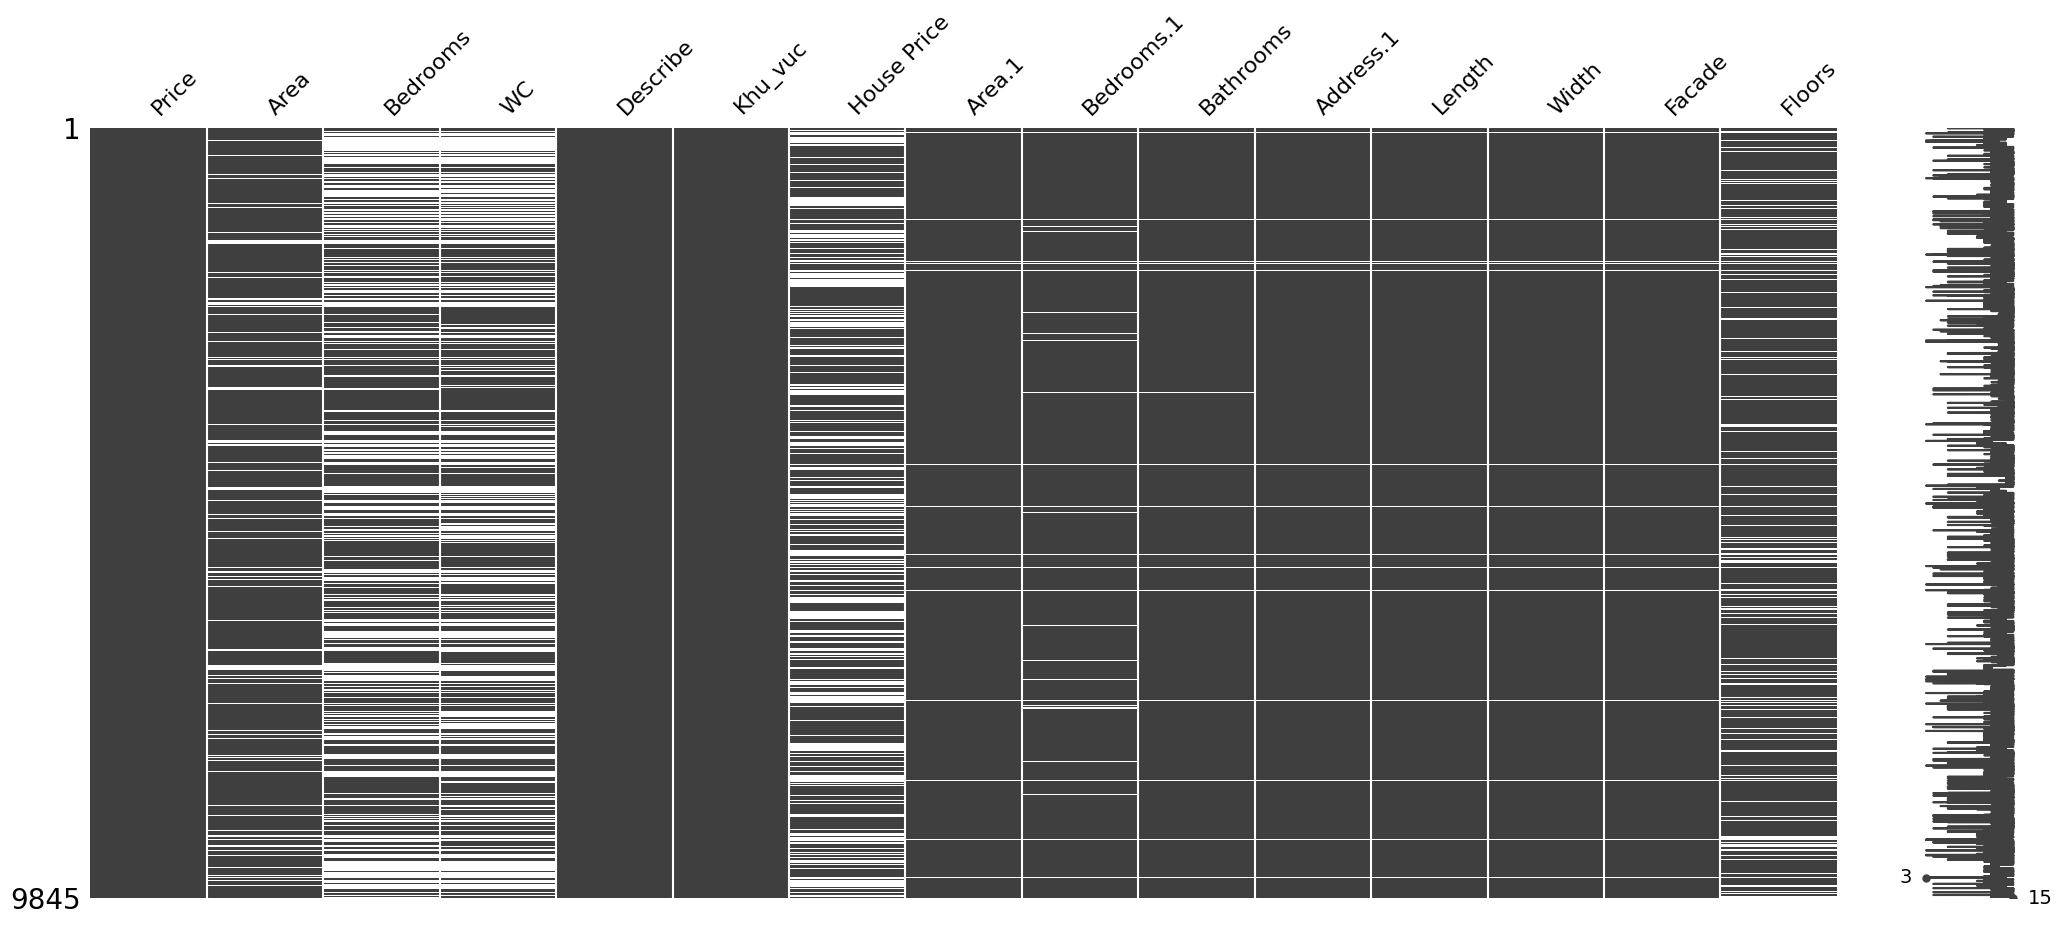

In [12]:
msno.matrix(df)

<h4> Tỷ lệ missing values ở 2 features Bedrooms và WC cũng được thể hiện rất rõ thông 2 biểu đồ trên <h4>

#Data preprocessing and Feature engineering

In [13]:
#Xử lý các cột Price, Area, Bedrooms, WC để lấy ra giá trị số và đơn vị
def split_price(value):
    if 'thỏa thuận' in value.lower():
        return '', 'Thỏa thuận'
    else:
        match = re.match(r"([0-9.]+)\s*(\w*)", value)
        if match:
            return match.groups()
        return '', ''

def split_Area(value):
    match = re.match(r"([0-9.]+)\s*(\w*)", value)
    if match:
        return match.groups()
    return '', ''

def split_Bedroom(value):
    number = value.split(' ')[0]
    return number if number.isdigit() else None

def split_WC(value):
    number = value.split(' ')[0]
    return number if number.isdigit() else None

<h4> Nhóm chúng em sẽ sử dụng bốn hàm này để xử lý các cột "Price", "Area", "Bedrooms" và "WC" từ một chuỗi đầu vào, nhằm lấy ra giá trị số và đơn vị

*  Đoạn mã đầu tiên: mục đích Xử lý cột "Price" để tách giá trị số và đơn vị.
*  Đoạn mã thứ hai: mục đích Xử lý cột "Area" để tách giá trị số và đơn vị
*  Đoạn mã thứ ba: mục đích xử lý cột "Bedrooms" để lấy số phòng ngủ.
*  Đoạn mã thứ tư: mục đích xử lý cột "WC" để lấy số phòng vệ sinh.




In [14]:
# thay thế các giá trị NaN bằng giá trị rỗng
df['Price'] = df['Price'].fillna('')
df['Area'] = df['Area'].fillna('')
df['Bedrooms'] = df['Bedrooms'].fillna('')
df['WC'] = df['WC'].fillna('')

#Áp dụng hàm xử lý cho các cột Price, Area, Bedrooms, WC

df[['Price', 'Unit']] = df['Price'].apply(lambda x: pd.Series(split_price(x)))
df[['Area', 'Unit1']] = df['Area'].apply(lambda x: pd.Series(split_Area(x)))
df['Bedrooms'] = df['Bedrooms'].apply(split_Bedroom)
df['WC'] = df['WC'].apply(split_WC)

<h4> Nhóm chúng em sẽ thay thế các giá trị NaN bằng giá trị rỗng nhằm tạo sự nhất quán trong việc fill missing values giai đoạn sau này. Nhóm chúng em sẽ xử lý trên 4 features Price, Area, Bedrooms, WC

In [15]:
df.head()

,Price,Area,Bedrooms,WC,Describe,Khu_vuc,House Price,Area.1,Bedrooms.1,Bathrooms,Address.1,Length,Width,Facade,Floors,Unit,Unit1
0,2.9,214,2,2,"- Nhà cấp 4, ngang 4m nở hậu 7.5m dài 37m công...",binhchanh,NaN,"214,","2,","2,","""Trần Văn Giàu"",","37,","4,","1,",NaN,tỷ,m2
1,12,200,12,12,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,"null,","null,","null,","null,","null,","null,","null,",NaN,triệu,m2
2,12,200,12,12,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,triệu,m2
3,850,60,3,2,Nhà 1 triệt 1 lầu 3phong ngủ 2wc\r\nDiện tích ...,binhchanh,NaN,"60,","3,","2,","null,","4,","15,","1,",1.0,triệu,m2
4,760,44,2,2,"Tình trạng\r\nMới\r\nBÁN NHÀ HẺM ĐƯỜNG AN HẠ, ...",binhchanh,NaN,"44,","2,","2,","""Đường An Hạ, Bình Chánh"",","11,","4,","0,",NaN,triệu,m2


In [16]:
df['House Price'] = df['House Price'].replace(r'[^\d.]', '', regex=True)
df['Area.1'] = df['Area.1'].replace(r'[^\d.]', '', regex=True)
df['Bedrooms.1'] = df['Bedrooms.1'].replace(r'[^\d.]', '', regex=True)
df['Bathrooms'] = df['Bathrooms'].replace(r'[^\d.]', '', regex=True)
df['Length'] = df['Length'].replace(r'[^\d.]', '', regex=True)
df['Width'] = df['Width'].replace(r'[^\d.]', '', regex=True)
df['Floors'] = df['Floors'].replace(r'[^\d.]', '', regex=True)
df['Facade'] = df['Facade'].replace(r'[^\d.]', '', regex=True)


<h4> Nhóm chúng em sẽ xử lý cột dữ liệu để giữ lại chỉ các ký tự số và dấu chấm (thập phân) <h4>

In [17]:
df.head()

,Price,Area,Bedrooms,WC,Describe,Khu_vuc,House Price,Area.1,Bedrooms.1,Bathrooms,Address.1,Length,Width,Facade,Floors,Unit,Unit1
0,2.9,214,2,2,"- Nhà cấp 4, ngang 4m nở hậu 7.5m dài 37m công...",binhchanh,NaN,214,2,2,"""Trần Văn Giàu"",",37,4,1,NaN,tỷ,m2
1,12,200,12,12,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,,,,"null,",,,,NaN,triệu,m2
2,12,200,12,12,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,triệu,m2
3,850,60,3,2,Nhà 1 triệt 1 lầu 3phong ngủ 2wc\r\nDiện tích ...,binhchanh,NaN,60,3,2,"null,",4,15,1,1.0,triệu,m2
4,760,44,2,2,"Tình trạng\r\nMới\r\nBÁN NHÀ HẺM ĐƯỜNG AN HẠ, ...",binhchanh,NaN,44,2,2,"""Đường An Hạ, Bình Chánh"",",11,4,0,NaN,triệu,m2


In [18]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['WC'] = pd.to_numeric(df['WC'], errors='coerce')
df['House Price'] = pd.to_numeric(df['House Price'], errors='coerce')
df['Area.1'] = pd.to_numeric(df['Area.1'], errors='coerce')
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')
df['Width'] = pd.to_numeric(df['Width'], errors='coerce')
df['Floors'] = pd.to_numeric(df['Floors'], errors='coerce')
df['Facade'] = pd.to_numeric(df['Facade'], errors='coerce')
df['Bedrooms.1'] = pd.to_numeric(df['Bedrooms.1'], errors='coerce')
df['Bathrooms'] = pd.to_numeric(df['Bathrooms'], errors='coerce')

<h4> Chuyển đổi dữ liệu của các features sang kiểu số để dễ dàng xử lý <h4>

In [19]:
df.head(5)

,Price,Area,Bedrooms,WC,Describe,Khu_vuc,House Price,Area.1,Bedrooms.1,Bathrooms,Address.1,Length,Width,Facade,Floors,Unit,Unit1
0,2.9,214.0,2.0,2.0,"- Nhà cấp 4, ngang 4m nở hậu 7.5m dài 37m công...",binhchanh,NaN,214.0,2.0,2.0,"""Trần Văn Giàu"",",37.0,4.0,1.0,NaN,tỷ,m2
1,12.0,200.0,12.0,12.0,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,NaN,NaN,NaN,"null,",NaN,NaN,NaN,NaN,triệu,m2
2,12.0,200.0,12.0,12.0,???? Discover the Power of Facebook Advertisin...,binhchanh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,triệu,m2
3,850.0,60.0,3.0,2.0,Nhà 1 triệt 1 lầu 3phong ngủ 2wc\r\nDiện tích ...,binhchanh,NaN,60.0,3.0,2.0,"null,",4.0,15.0,1.0,1.0,triệu,m2
4,760.0,44.0,2.0,2.0,"Tình trạng\r\nMới\r\nBÁN NHÀ HẺM ĐƯỜNG AN HẠ, ...",binhchanh,NaN,44.0,2.0,2.0,"""Đường An Hạ, Bình Chánh"",",11.0,4.0,0.0,NaN,triệu,m2


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        9007 non-null   float64
 1   Area         8881 non-null   float64
 2   Bedrooms     6020 non-null   float64
 3   WC           5749 non-null   float64
 4   Describe     9845 non-null   object 
 5   Khu_vuc      9845 non-null   object 
 6   House Price  4805 non-null   float64
 7   Area.1       7738 non-null   float64
 8   Bedrooms.1   6665 non-null   float64
 9   Bathrooms    5366 non-null   float64
 10  Address.1    9599 non-null   object 
 11  Length       6785 non-null   float64
 12  Width        6896 non-null   float64
 13  Facade       8668 non-null   float64
 14  Floors       8339 non-null   float64
 15  Unit         9845 non-null   object 
 16  Unit1        9845 non-null   object 
dtypes: float64(12), object(5)
memory usage: 1.3+ MB


#Handling missing value

Price

In [23]:
#Cột Unit có 4 kiểu giá trị: Thỏa thuận,tỷ, triệu,nghìn
value_counts = df['Unit'].value_counts()
print(value_counts)

Unit
tỷ            8826
Thỏa thuận     838
triệu          177
nghìn            4
Name: count, dtype: int64


In [24]:
#có rất ít  giá trị có đơn vị nghìn nên loại bỏ các giá trị này
df = df.loc[df['Unit'] != 'nghìn']
#Chọn tỷ làm đơn vị chung để chuyển các giá trị về cùng đơn vị
df['Price'] = np.where(df['Unit'] == 'triệu', df['Price'] / 1000, df['Price'])
#Thay thế các giá trị rỗng ở cột Price bằng giá trị của cột House Price nếu  có  giá trị
df['Price'] = df['Price'].fillna(df['House Price'])
#Cột Price  có các  giá trị rất lớn do nhập sai định dạng
df.loc[df['Price'] > 100000000, 'Price'] = df['Price'] / 1000000000
#So sánh với các kết quả thực tế tình hình bất động sản trên cả nước thì giá nhà tối đa là 2 tỷ / m^2. Vì thế nhóm chúng em sẽ lọc các bộ dữ liệu thõa mãn điều trên
df = df.loc[(df['Price']/df['Area'])<=2]



<ipython-input-24-1ecd8815b9df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = np.where(df['Unit'] == 'triệu', df['Price'] / 1000, df['Price'])
<ipython-input-24-1ecd8815b9df>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].fillna(df['House Price'])


Area

In [25]:
#Thay thế các giá trị rỗng ở cột Area bằng giá trị của cột Area.1 nếu có giá trị
df['Area'] = df['Area'].fillna(df['Area.1'])
#Diện tích nhà = chiều dài x chiều rộng
df['Length']=df['Length'].fillna(df['Area']/df['Width'])
df['Width']=df['Width'].fillna(df['Area']/df['Length'])
df['Area'] = df['Area'].fillna(df['Length']*df['Width'])

In [26]:
#Thay thế các giá trị rỗng ở cột Bedrooms bằng giá trị của cột Bedrooms.1 nếu có giá trị
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms.1'])
#Thay thế các giá trị rỗng ở cột WC bằng giá trị của cột Bathrooms nếu có giá trị
df['WC'] = df['WC'].fillna(df['Bathrooms'])


In [54]:
#Nhóm em sẽ sử dụng KNN để fill null cho 'Bedrooms' và 'WC', trong đó có thiết lập trọng số với 3 feature là 'Price','Area','Floors' vì theo tình hình thực tế thì
# ba features trên sẽ đóng vai trò quan trọng trong việc xây nhà vệ sinh và toilet cho một ngôi nhà
from sklearn.impute import KNNImputer

# Thiết lập KNNImputer với weighted distance
# Nhóm chúng em chọn các trọng số 0.1 cho Price, 0.1 cho Area và 0.8 cho Floors dựa vào kiến thức thực tế rằng số phòng ngủ thường phụ thuộc
# nhiều vào số tầng của căn nhà, và cũng như giá và diện tích sẽ chiếm tỷ trọng nhỏ hơn
weights = {
    'Price': 0.1,
    'Area': 0.1,
    'Floors': 0.8
}

# Lấy các feature và chuẩn bị dữ liệu cho KNNImputer
features = ['Price', 'Area', 'Floors','Bedrooms']
X = df[features].values

# Khởi tạo và fit KNNImputer với weighted distance
imputer = KNNImputer(n_neighbors=25, weights='distance', metric='nan_euclidean', add_indicator=False)
X_imputed = imputer.fit_transform(X)

# Cập nhật dữ liệu vào DataFrame
df['Bedrooms'] = X_imputed[:, features.index('Bedrooms')]

# Hiển thị kết quả
print(df)

      Price   Area  Bedrooms        WC  Length  Width  Floors  has_facade  \
0      2.90  143.5       2.0  2.000000   33.10    4.0     1.0           1   
3      0.85   60.0       3.0  2.000000    4.00   15.0     1.0           1   
4      0.76   44.0       2.0  2.000000   11.00    4.0     1.0           0   
7      0.60  100.0       2.0  2.000000    5.30   14.0     1.0           1   
9      0.69  143.5       3.0  2.000000   19.00    4.0     1.0           1   
...     ...    ...       ...       ...     ...    ...     ...         ...   
9832  16.20  143.5       7.0  7.071193   33.10   17.1     4.0           1   
9837   5.30   79.0       2.0  2.000000   19.00    4.2     1.0           1   
9840   3.30   40.0       4.0  2.000000   10.00    4.0     3.0           1   
9842  13.00   52.8       4.0  5.000000    2.64   20.0     4.0           1   
9844   5.60  112.0       3.0  2.000000   28.00    4.0     2.0           1   

      no_facade  Area_Total  Average_price  
0             0       214.0   

In [28]:
# Tương tự với nhà vệ sinh
from sklearn.impute import KNNImputer
# Thiết lập KNNImputer với weighted distance
# Nhóm chúng em chọn các trọng số 0.1 cho Price, 0.1 cho Area và 0.8 cho Floors dựa vào kiến thức thực tế rằng số nhà vệ sinh cũng thường phụ thuộc
# nhiều vào số tầng của căn nhà, và cũng như giá và diện tích sẽ chiếm tỷ trọng nhỏ hơn
weights = {
    'Price': 0.1,
    'Area': 0.1,
    'Floors': 0.8
}

# Lấy các feature và chuẩn bị dữ liệu cho KNNImputer
features = ['Price', 'Area', 'Floors','WC']
X = df[features].values

# Khởi tạo và fit KNNImputer với weighted distance
imputer = KNNImputer(n_neighbors=25, weights='distance', metric='nan_euclidean', add_indicator=False)
X_imputed = imputer.fit_transform(X)

# Cập nhật dữ liệu vào DataFrame
df['WC'] = X_imputed[:, features.index('WC')]

# Hiển thị kết quả
print(df)


       Price   Area   Bedrooms         WC  \
0      2.900  214.0   2.000000   2.000000   
1      0.012  200.0  12.000000  12.000000   
2      0.012  200.0  12.000000  12.000000   
3      0.850   60.0   3.000000   2.000000   
4      0.760   44.0   2.000000   2.000000   
...      ...    ...        ...        ...   
9840   3.300   40.0   4.000000   2.000000   
9841   7.000  170.0   4.428971   4.117318   
9842  13.000   52.8   4.000000   5.000000   
9843   4.550   47.0   2.000000   2.000000   
9844   5.600  112.0   3.000000   2.000000   

                                               Describe    Khu_vuc  \
0     - Nhà cấp 4, ngang 4m nở hậu 7.5m dài 37m công...  binhchanh   
1     ???? Discover the Power of Facebook Advertisin...  binhchanh   
2     ???? Discover the Power of Facebook Advertisin...  binhchanh   
3     Nhà 1 triệt 1 lầu 3phong ngủ 2wc\r\nDiện tích ...  binhchanh   
4     Tình trạng\r\nMới\r\nBÁN NHÀ HẺM ĐƯỜNG AN HẠ, ...  binhchanh   
...                                    

In [29]:
df['Floors'] = df['Floors'].fillna(1)

<h4> Nhóm chúng em đề xuất rằng đối với những bộ dữ liệu có missing value ở Floors thì sẽ mặc định là 1 vì nếu như theo tâm lý của người bán thì nếu như bất động sản có nhiều hơn 1 tầng thì sẽ ghi trong mô tả nằm tăng giá trị đối với bất động sản ấy <h4>

In [30]:
df['Facade'] = df['Facade'].fillna(0)
#mã hoá One-hot
# Tạo cột 'has_facade'
df['has_facade'] = df['Facade'].apply(lambda x: 1 if x == 1 else 0)

# Tạo cột 'no_facade'
df['no_facade'] = df['Facade'].apply(lambda x: 1 if x == 0 else 0)

<h4> Nhóm chúng em đề xuất rằng đối với những bộ dữ liệu có missing value ở Facade ( mặt tiền ) thì sẽ mặc định là 0 vì nếu như theo tâm lý của người bán thì nếu như bất động sản ở vị trí mặt tiền thì sẽ ghi trong mô tả nằm tăng giá trị đối với bất động sản ấy. Đồng thời áp dụng mã hóa One-hot encoder đối với column này
 <h4>

In [31]:
df=df[['Price', 'Area', 'Bedrooms', 'WC', 'Length', 'Width', 'Floors', 'has_facade','no_facade','Khu_vuc']]

#Feature engineering

<h4> Sau khi đã fill null từ dữ liệu của mô tả bằng LLM và xử lý các giá trị null còn lại thì dataset cuối cùng sẽ bao gồm các feature như trên <h4>

In [32]:
#Feature Engineering (thêm 1 feature mới)
df['Area_Total']=df['Area']*df['Floors']

<ipython-input-32-344741b3c7db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Area_Total']=df['Area']*df['Floors']


<h4>

 Encoding categorical variables

In [33]:
df.describe()

,Price,Area,Bedrooms,WC,Length,Width,Floors,has_facade,no_facade,Area_Total
count,8257.000000,8257.000000,8257.000000,8257.000000,6131.000000,6131.000000,8257.000000,8257.000000,8257.000000,8257.000000
mean,8.997100,83.269300,3.957295,3.711800,11.416713,8.727336,3.275403,0.829115,0.170764,292.935641
std,16.777402,386.046252,4.076436,3.876787,7.881548,7.853188,45.426513,0.376432,0.376326,4212.130753
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.900000,1.000000,0.000000,0.000000,8.000000
25%,4.000000,45.000000,2.000000,2.000000,4.600000,4.000000,2.000000,1.000000,0.000000,90.000000
50%,5.700000,60.000000,3.000000,3.000000,11.000000,5.500000,3.000000,1.000000,0.000000,147.000000
75%,8.600000,81.000000,4.000000,4.000000,16.000000,12.000000,4.000000,1.000000,0.000000,240.000000
max,500.000000,32825.000000,127.000000,127.000000,180.000000,300.000000,4112.000000,1.000000,1.000000,351987.200000


In [34]:
#Bỏ các hàng có giá trị null
df = df.dropna()

In [35]:
df.head(20)

,Price,Area,Bedrooms,WC,Length,Width,Floors,has_facade,no_facade,Khu_vuc,Area_Total
0,2.90,214.0,2.0,2.00000,37.0,4.000000,1.0,1,0,binhchanh,214.0
3,0.85,60.0,3.0,2.00000,4.0,15.000000,1.0,1,0,binhchanh,60.0
4,0.76,44.0,2.0,2.00000,11.0,4.000000,1.0,0,1,binhchanh,44.0
7,0.60,100.0,2.0,2.00000,5.3,14.000000,1.0,1,0,binhchanh,100.0
9,0.69,152.0,3.0,2.00000,19.0,4.000000,1.0,1,0,binhchanh,152.0
10,5.50,184.0,3.0,5.04324,23.0,8.000000,2.0,1,0,binhchanh,368.0
11,0.85,200.0,3.0,2.00000,7.0,28.571429,2.0,1,0,binhchanh,400.0
12,0.69,150.0,3.0,2.00000,20.0,4.000000,1.0,1,0,binhchanh,150.0
13,0.57,75.0,2.0,2.00000,4.0,15.000000,2.0,1,0,binhchanh,150.0
14,0.68,160.0,2.0,2.00000,16.0,4.000000,1.0,1,0,binhchanh,160.0


In [36]:
df.columns


Index(['Price', 'Area', 'Bedrooms', 'WC', 'Length', 'Width', 'Floors',
       'has_facade', 'no_facade', 'Khu_vuc', 'Area_Total'],
      dtype='object')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6131 entries, 0 to 9844
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       6131 non-null   float64
 1   Area        6131 non-null   float64
 2   Bedrooms    6131 non-null   float64
 3   WC          6131 non-null   float64
 4   Length      6131 non-null   float64
 5   Width       6131 non-null   float64
 6   Floors      6131 non-null   float64
 7   has_facade  6131 non-null   int64  
 8   no_facade   6131 non-null   int64  
 9   Khu_vuc     6131 non-null   object 
 10  Area_Total  6131 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 574.8+ KB


#Remove outlier

In [38]:
def wisker(col):
  """
  Tính toán giới hạn dưới và giới hạn trên cho các giá trị ngoại lai sử dụng phương pháp whisker.

  Tham số:
  col (array-like): Cột hoặc mảng đầu vào.

  Trả về:
  tuple: Một tuple chứa giới hạn dưới và giới hạn trên cho các giá trị ngoại lai.
  """
  q1, q3 = np.percentile(col, [25, 75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return lower_bound, upper_bound

In [39]:
# Áp dụng phương pháp whisker để xử lý các giá trị ngoại lai
for i in ['Price', 'Area', 'Bedrooms', 'WC', 'Length', 'Width', 'Floors','Area_Total']:
  lower_bound, upper_bound = wisker(df[i])
  df[i] = np.where(df[i] < lower_bound, lower_bound, df[i])
  df[i] = np.where(df[i] > upper_bound, upper_bound, df[i])

In [40]:
#Mã hoá target:Mã hóa dựa trên giá nhà trung bình của mỗi khu vực
average_price = df.groupby('Khu_vuc')['Price'].mean()
print(average_price)

Khu_vuc
binhchanh     3.349500
binhtan       6.094127
binhthanh     7.917305
cuchi         0.840143
govap         6.550366
hocmon        2.568825
nhabe         7.548708
phunhuan      7.255279
q1           14.334461
q10           9.584767
q11           7.984375
q12           5.150961
q2           10.642418
q3            9.831009
q4            5.419474
q5            8.282525
q7            7.993925
q8            5.277894
q9            6.753271
tanbinh       7.411881
tanphu        6.794721
thuduc        8.718758
Name: Price, dtype: float64


In [41]:
df['Average_price'] = df['Khu_vuc'].map(average_price)

In [42]:
df.drop('Khu_vuc',axis=1,inplace=True)

#Exploratory Data Analysis after Data preprocessing and Feature engineering

**Data distribution**

count    6131.000000
mean        7.200962
std         4.313158
min         0.000000
25%         4.200000
50%         5.900000
75%         9.000000
max        16.200000
Name: Price, dtype: float64


<ipython-input-43-87a3f29fe06b>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Price'], color='g', bins=100, hist_kws={'alpha': 0.4});


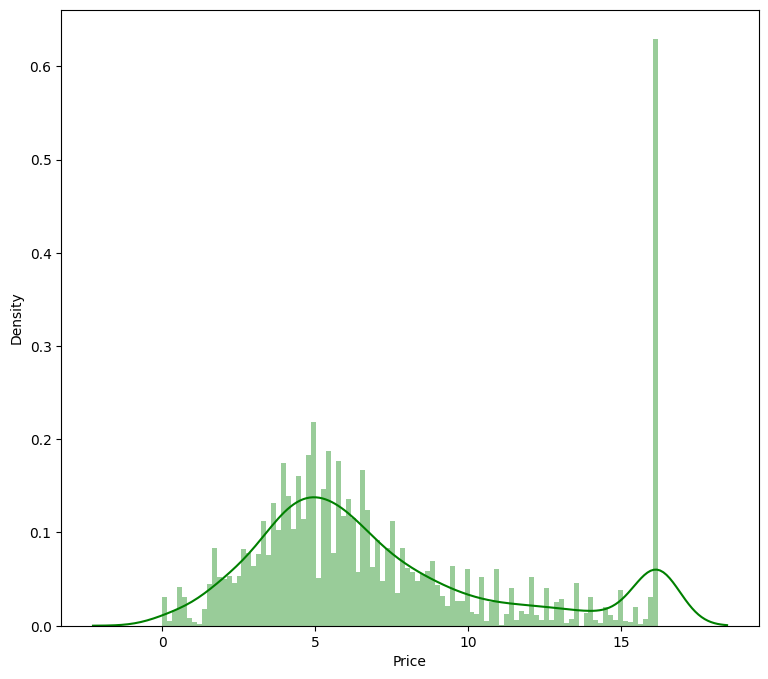

In [43]:
#Sử dụng phương thức describe() để tính toán các thống kê mô tả cho cột target 'Price'
print(df['Price'].describe())
#Vẽ đồ thị phân phối của 'Price' trong tập dữ liệu
plt.figure(figsize=(9, 8))
sns.distplot(df['Price'], color='g', bins=100, hist_kws={'alpha': 0.4});



*   Thông qua biểu đồ này ta có thể nhận biết được hình dạng của phân phối giá trị. Ở đây cho thấy dữ liệu có phân phối Gaussian. Cho thấy giá trị Price có xu hướng phân phố đồng đều trong tập dữ liệu.



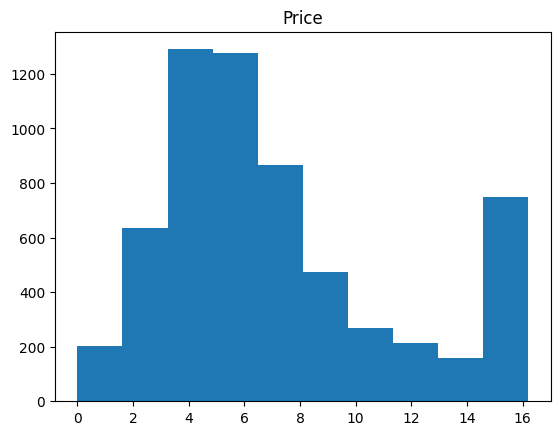

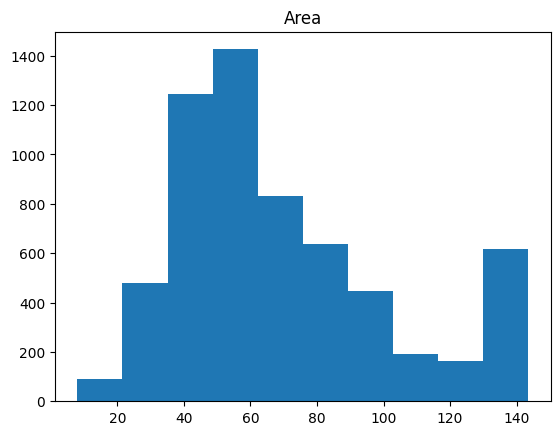

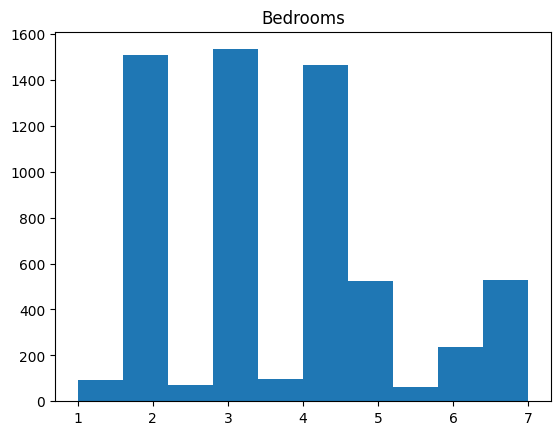

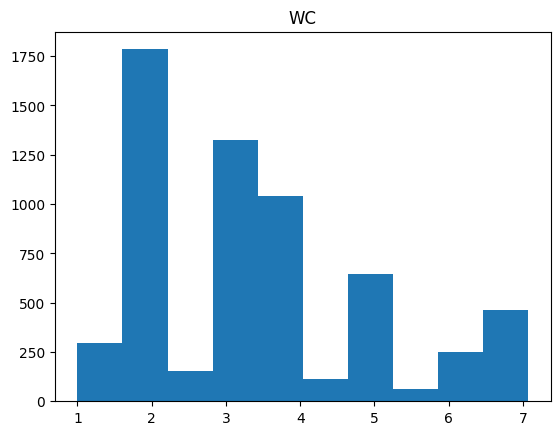

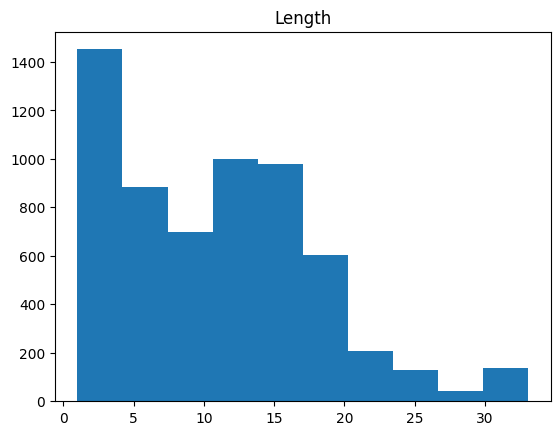

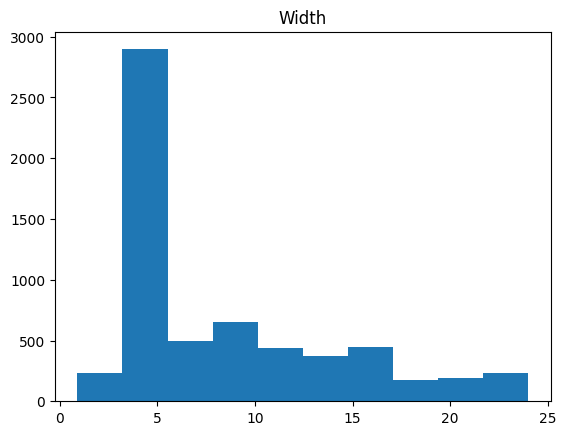

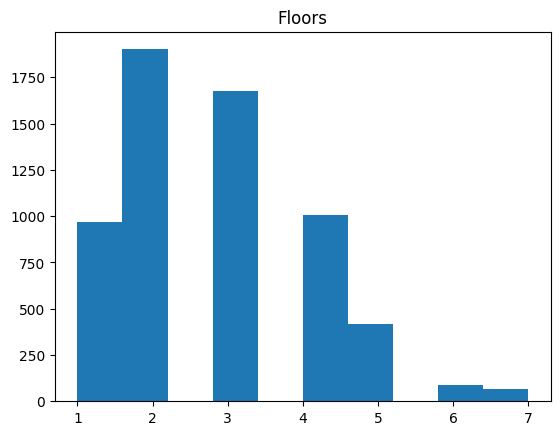

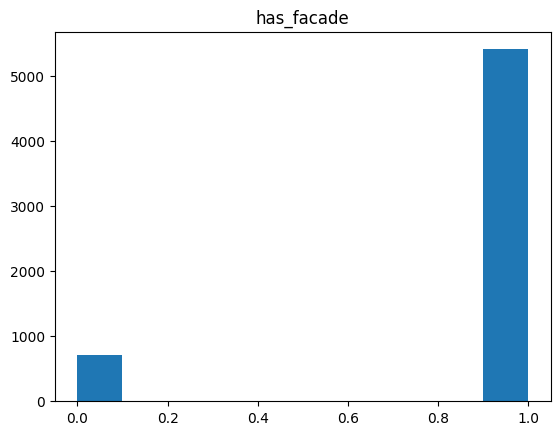

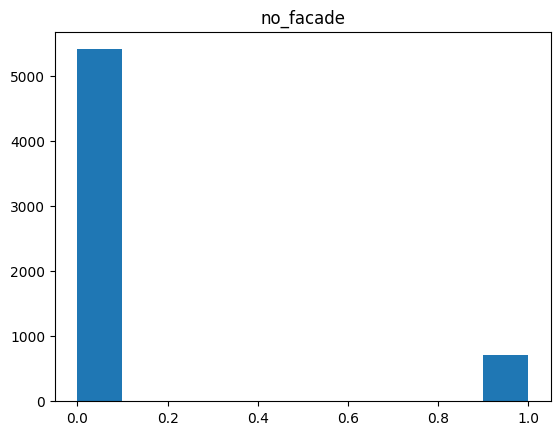

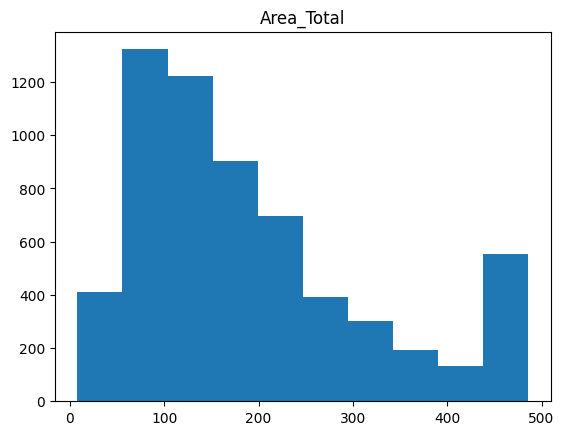

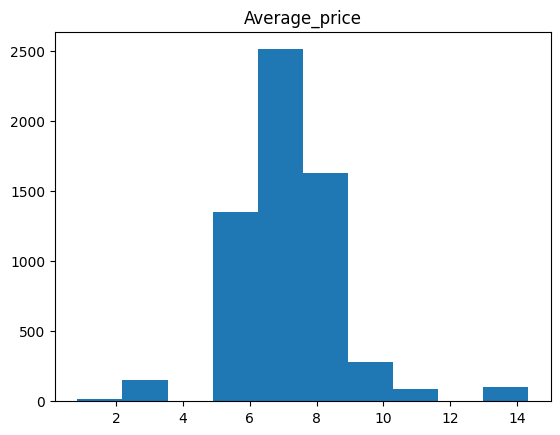

In [44]:
#Vẽ biểu đồ histogram để hiểu distribution của dữ liệu
for i in df.select_dtypes(include='number').columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()

<h4> Các biểu đồ histogram về các feature sau khi đã xử lý dữ liệu đều có một số bộ dữ liệu có giá cao  và đồng thời số phòng ngủ, số WC cao hơn các feature còn lại , điều này là đúng với thực tế đối với các vị trí đắc địa trên địa bàn Thành phố Hồ Chí Minh <h4>

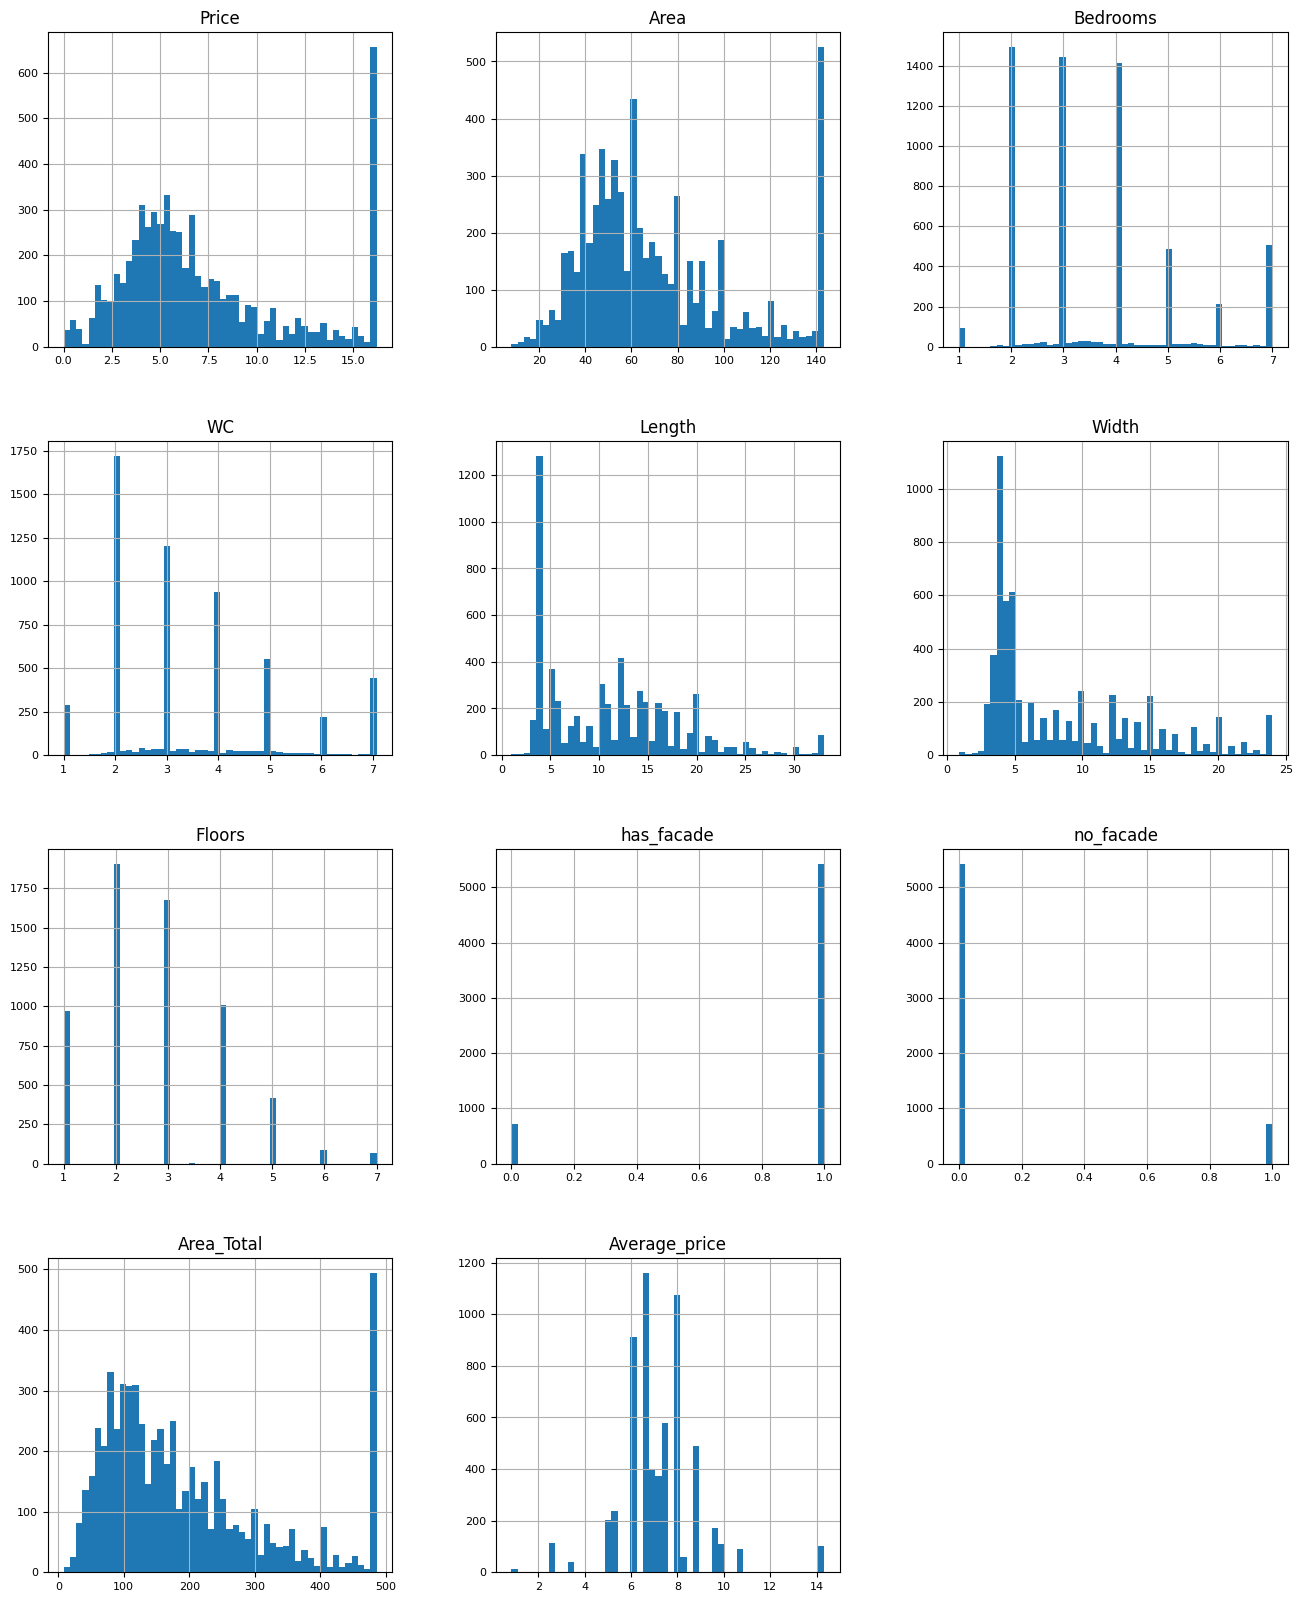

In [45]:
#Tiếp tục vẽ thêmm biểu đồ để hiểu hơn về phân phối của các feature trong tập dữ liệu.
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

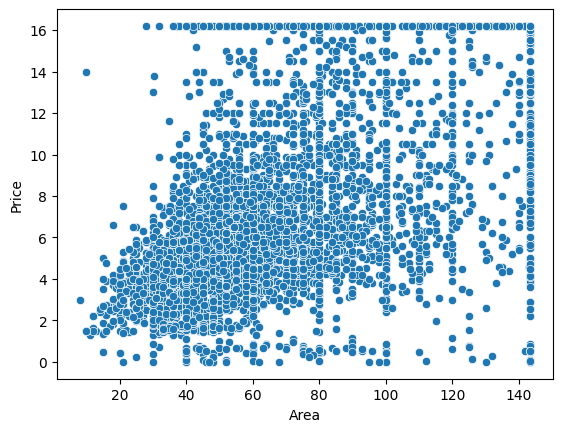

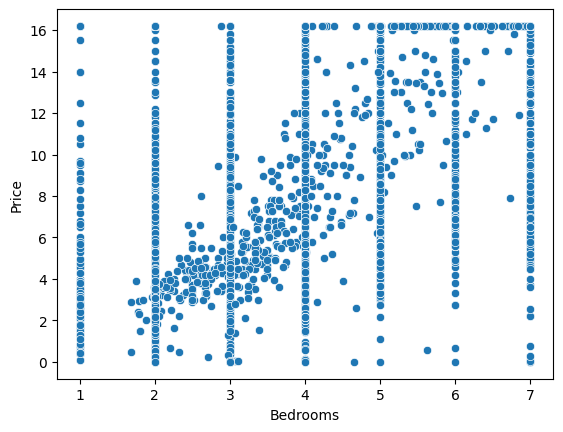

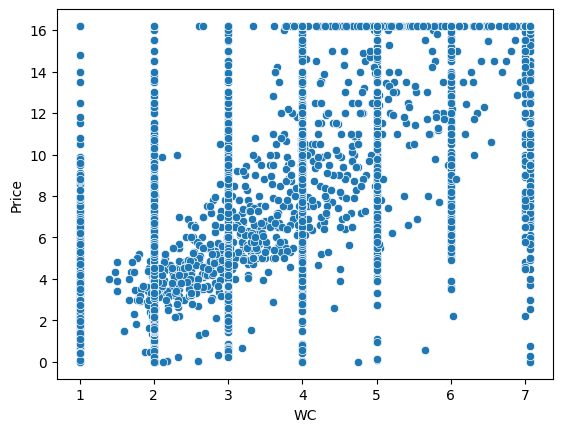

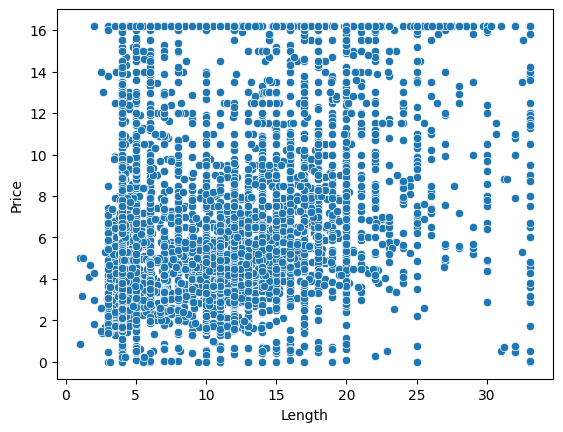

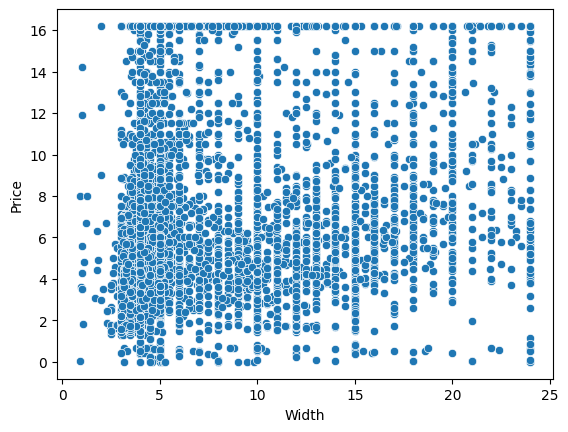

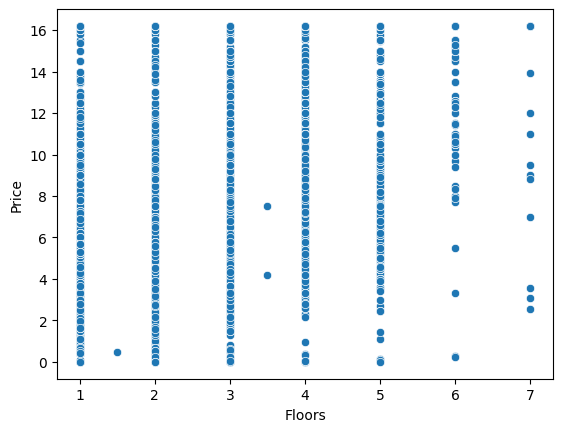

In [46]:
#scatter plot to understand the relationship Vẽ các đồ thị phân tán để hiểu được mối quan hệ giữa cột
#Price với mỗi cặp khác trong dataframe
for i in ['Area', 'Bedrooms', 'WC','Length', 'Width', 'Floors']:
  sns.scatterplot(data = df,  x= i, y='Price')
  plt.show()


**Sử dụng thư viện sweetviz để EDA**

In [47]:
!pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 33.1 MB/s eta 0:00:00


Công cụ mã nguồn mở được sử dụng để tạo báo cáo tự động về khám phá dữ liệu (EDA - Exploratory Data Analysis)

In [48]:
import sweetviz as sv

report = sv.analyze(df)
report.show_html('report.html') # Muốn lưu cái này dưới dạng html và lưu trong storage của GG Colab

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Tạo ra các báo cáo trực quan và có thể được lưu dưới dạng tệp HTML để dễ dàng chia sẻ và xem lại. Bao gồm các thông tin về các biến, phân phối, tương quan, quan hệ giữa các biến, giá trị thiếu, và các thống kê mô tả.

**Correlation**

In [49]:
#Ma trận tương quan giữa các cột dạng số trong dataframe df.
#correlation với bản đồ nhiệt để diễn giải mối tương quan và đa cộng tuyến
df.select_dtypes(include='number').corr()

,Price,Area,Bedrooms,WC,Length,Width,Floors,has_facade,no_facade,Area_Total,Average_price
Price,1.000000,0.619150,0.638388,0.634235,0.353590,0.228860,0.405474,0.069307,-0.069113,0.685507,0.383768
Area,0.619150,1.000000,0.534785,0.473544,0.514580,0.345963,0.127785,0.081345,-0.081132,0.740173,0.079773
Bedrooms,0.638388,0.534785,1.000000,0.829592,0.282764,0.215804,0.512128,0.054025,-0.053847,0.676085,0.243126
WC,0.634235,0.473544,0.829592,1.000000,0.250981,0.198332,0.538616,0.063693,-0.063315,0.667464,0.234268
Length,0.353590,0.514580,0.282764,0.250981,1.000000,-0.483378,0.071788,0.068536,-0.068708,0.394354,0.071250
Width,0.228860,0.345963,0.215804,0.198332,-0.483378,1.000000,0.045992,0.006606,-0.006207,0.265179,-0.018562
Floors,0.405474,0.127785,0.512128,0.538616,0.071788,0.045992,1.000000,0.038167,-0.037886,0.691474,0.187818
has_facade,0.069307,0.081345,0.054025,0.063693,0.068536,0.006606,0.038167,1.000000,-0.999209,0.081472,-0.051596
no_facade,-0.069113,-0.081132,-0.053847,-0.063315,-0.068708,-0.006207,-0.037886,-0.999209,1.000000,-0.081174,0.051387
Area_Total,0.685507,0.740173,0.676085,0.667464,0.394354,0.265179,0.691474,0.081472,-0.081174,1.000000,0.168640


Cho biết mức độ tương quan giữa các cặp cột trong dataframe.

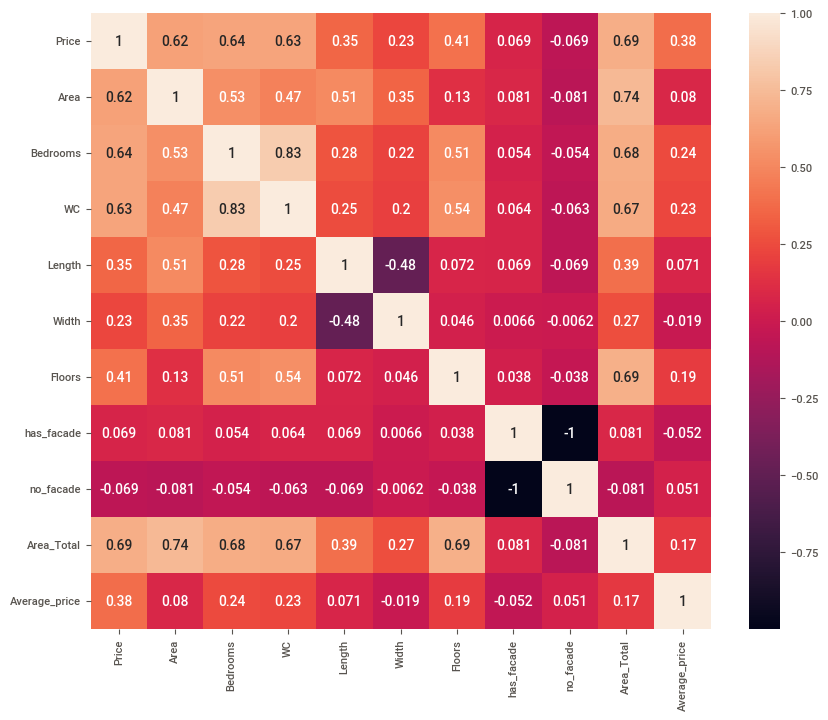

In [50]:
#heatmap ma trận tương quan để quan sát mối tương quan giữa các cặp cột trong dataframe
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(),annot = True )
plt.show()

Theo như đồ thị thì Column Facde có độ tương quan thấp với biến Target 'Price' là -0.0067 nên chúng ta sẽ drop 'Facade' ra khỏi dataframe df.

In [51]:
X = df.copy()
y = X.pop("Price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores


Area_Total       0.521443
Area             0.445909
WC               0.370057
Bedrooms         0.348638
Average_price    0.248475
Length           0.221211
Width            0.183849
Floors           0.171457
has_facade       0.010657
no_facade        0.010562
Name: MI Scores, dtype: float64

<h4> Điểm mi_scores của các feature <h4>

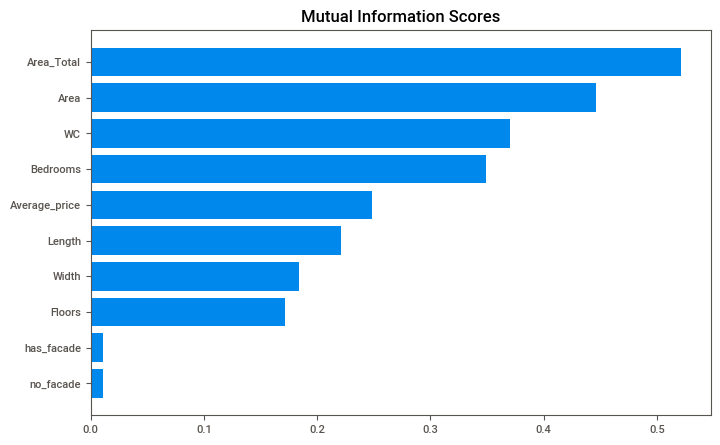

In [52]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<h4> Từ MI scores và Pearson scores, thì MI scores có thể phát hiện cả mối quan hệ tuyến tính và phi tuyến giữa hai biến, điều mà các thước đo như hệ số tương quan Pearson không thể làm được. Và từ đó cũng đánh giá được những features nào là quan trọng đối với mô hình vì MI scores đánh giá lượng thông tin mà hai biến chia sẻ. Giá trị càng cao, nghĩa là càng có nhiều thông tin chung giữa hai biến. <h4>


In [53]:
df.to_csv('data_final.csv',index=False)